# 2D GRF data Regression with domain-decomposed OpFlow
case2, strip observations

run ``2D_domain_decomposed_GRF_prior.ipynb`` first

### load necessary libraries

In [1]:
from __future__ import division

from sklearn import cluster, datasets, mixture
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
import torch
import torch.nn as nn 
from math import pi 
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from torch.distributions.multivariate_normal import MultivariateNormal
import math
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
import pylab as plt
import statsmodels.api as sm
#from random_fields import *

import timeit
from matplotlib.colors import TwoSlopeNorm

In [2]:
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = "5"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(1)

In [3]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

def GaussianProcess_2C(ndim, length_scale, nu, n_samples, return_kernel=False, nchannel = 1):
    x = np.linspace(0, 1, ndim)
    y = np.linspace(0, 1, ndim)
    XX, YY = np.meshgrid(x, y)
    XX = XX.reshape(-1, 1)
    YY = YY.reshape(-1, 1)
    X = np.concatenate([XX, YY], axis=1)
    print(X.shape)
    kernel = 1.0 * Matern(length_scale=length_scale, length_scale_bounds=(1e-1, 10.0), nu=nu)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    if nchannel == 1:
        y_samples = gpr_model.sample_y(X, n_samples)[:,:,np.newaxis]
    else:
        arr = []
        a = gpr_model.sample_y(X, n_samples*nchannel)[:,:,None]
        for i in range(nchannel):
            arr.append(a[:,n_samples*i:n_samples*(i+1),:])
        y_samples = np.concatenate(arr, axis=-1)
        assert(y_samples.shape == np.zeros([ndim*ndim, n_samples, nchannel]).shape)
        
    if return_kernel:
        return torch.tensor(y_samples), kernel(X), gpr_model
    else:
        return torch.tensor(y_samples)
    
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means

### dataset parameters and preparation

In [4]:
ntrain = 20000
nchannel = 1
ndim = 32
batch_size = 256

length_scale_x = 0.5
nu_x = 1.5

length_scale_z = 0.1
nu_z = 0.5

Starting up. Generate GRF samples
(1024, 2)
(1024, 2)


/home/yshi5/miniconda3/envs/Pytorch/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755849709/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


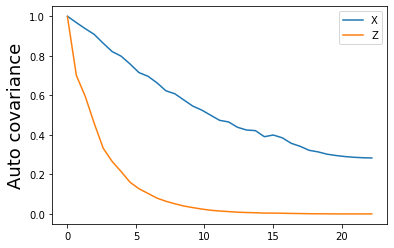

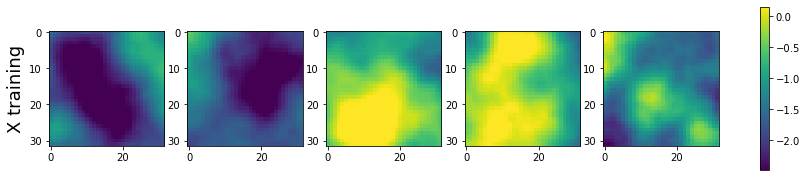

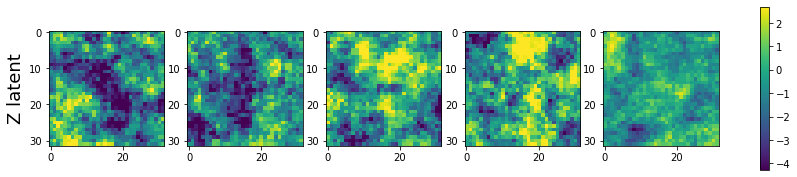

In [5]:
print("Starting up. Generate GRF samples")
import statsmodels.api as sm

np.random.seed(22)

x_train = GaussianProcess_2C(ndim, length_scale_x, nu_x, ntrain, return_kernel=False, nchannel=nchannel)
x_train = x_train.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the autocov 
z_train, kernel, z_gpmodel = GaussianProcess_2C(ndim, length_scale_z, nu_z, 2*ntrain, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the statistics 
x_distance, x_acovf_mean = compute_acovf(x_train[:,:,:,0])
z_distance, z_acovf_mean = compute_acovf(z_train[:,:,:,0])

plt.plot(x_distance, x_acovf_mean, label='X')
plt.plot(z_distance, z_acovf_mean, label='Z')
plt.legend()
plt.ylabel("Auto covariance", fontsize=18)

fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    x = x_train[i,:,:,0].squeeze()
    ax[i].imshow(x, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('X training', fontsize=18)

#cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
bar = ax[4].imshow(x)
fig.colorbar(bar, ax=ax)
#plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,3))    
for i in range(5):
    z = z_train[i,:,:,0].squeeze()
    ax[i].imshow(z, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('Z latent', fontsize=18)
              
bar = ax[4].imshow(z)
fig.colorbar(bar, ax=ax)

# load dataset

In [6]:
def kernel_loc(in_chan=2, up_dim=32):
    """
        Kernel network apply on grid
    """
    layers = nn.Sequential(
                nn.Linear(in_chan, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, 1, bias=False)
            )
    return layers

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, dim1, dim2,modes1 = None, modes2 = None):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """
        in_channels = int(in_channels)
        out_channels = int(out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dim1 = dim1 #output dimensions
        self.dim2 = dim2
        if modes1 is not None:
            self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
            self.modes2 = modes2
        else:
            self.modes1 = dim1//2-1 #if not given take the highest number of modes can be taken
            self.modes2 = dim2//2 
        self.scale = (1 / (2*in_channels))**(1.0/2.0)
        self.weights1 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))
        self.weights2 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x, dim1 = None,dim2 = None):
        if dim1 is not None:
            self.dim1 = dim1
            self.dim2 = dim2
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1 , dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft)
        #x = torch.fft.irfft2(out_ft, s=(self.dim1, self.dim2))
        return x



class pointwise_op(nn.Module):
    def __init__(self, in_channel, out_channel,dim1, dim2):
        super(pointwise_op,self).__init__()
        self.conv = nn.Conv2d(int(in_channel), int(out_channel), 1)
        self.dim1 = int(dim1)
        self.dim2 = int(dim2)

    def forward(self,x, dim1 = None, dim2 = None):
        if dim1 is None:
            dim1 = self.dim1
            dim2 = self.dim2
        x_out = self.conv(x)
        #x_out = torch.nn.functional.interpolate(x_out, size = (dim1, dim2),mode = 'bicubic',align_corners=True)
        return x_out

In [7]:
class FNO2d(nn.Module):
    def __init__(self, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        #self.modes1 = modes1
        #self.modes2 = modes2
        self.width = width
        self.padding = 0 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)
        
        self.conv0 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)

        self.conv1 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)
        
        self.conv2 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)

        self.conv3 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)
        
        self.w0 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w1 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w2 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w3 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.fc1 = nn.Linear(self.width, 2*self.width)
        # first three are normalized 3C waveforms, last three are associated PGAs
        self.fc2 = nn.Linear(2*self.width, 2) # s and t


    def forward(self, x):
        res1 = x.shape[1]
        res2 = x.shape[2]
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
         
        x_fc0 = self.fc0(x)
        x_fc0 = F.gelu(x_fc0)
        
        x_fc0 = x_fc0.permute(0, 3, 1, 2)
        #x_fc0 = F.pad(x_fc0, [0,self.padding, 0,self.padding])
        
        x1 = self.conv0(x_fc0)
        x2 = self.w0(x_fc0)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        x = x.permute(0, 2, 3, 1)

        x_fc1 = self.fc1(x)
        x_fc1 = F.gelu(x_fc1)

        x_out = self.fc2(x_fc1)

        return x_out
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [8]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()
        
        self.loc = nn.Parameter(torch.zeros(1, 1, 1, in_channel))
        self.log_scale = nn.Parameter(torch.zeros(1, 1, 1, in_channel))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            #flatten = input.permute(1, 0, 2).contiguous().view(input.shape[1], -1)
            mean = input.mean(dim=(0,1,2)).unsqueeze(0).unsqueeze(1).unsqueeze(2)
            std = input.std(dim=(0,1,2)).unsqueeze(0).unsqueeze(1).unsqueeze(2)

            self.loc.data.copy_(-mean)
            self.log_scale.data.copy_(torch.log(1 / (std + 1e-6)))

    def forward(self, input):
        batch_size, ndim1, ndim2, _ = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        scale = torch.exp(self.log_scale)
        output = scale * (input + self.loc)        

        logdet = batch_size * ndim1 * ndim2 * self.log_scale.sum() #pointwise operation
        
        return output, logdet


    def inverse(self, output):
        #_, length, wdith, _ = output.shape
        scale = torch.exp(self.log_scale)
        output = output / scale - self.loc
        #logdet = -1.0 * width * length * self.log_scale.sum()
        
        #return output, logdet
        return output

In [9]:
class AffineCoupling(nn.Module):
    def __init__(self, width, block_dim):
        super(AffineCoupling, self).__init__()
        """
        A single affine coupling operator block
        This layer splits the input spatially and computes scale and shift functions
        It consists of two FNO networks to compute scale and shift functions
        The scale and shift functions are then used to transform the other
        half of the input function
        """
        self.width = width
        self.coupling = FNO2d(width)
        self.k = block_dim
        self.actnorm = ActNorm(1)

    def forward(self, z, flip=False):
        x = z
        x, log_actnorm = self.actnorm(x)
        n_rep = x.shape[2] // (2*self.k) + 1
        mask_a = torch.eye(2, device=x.device).bool()
        mask_a = mask_a.repeat_interleave(self.k, dim=1).repeat_interleave(self.k, dim=0).tile(n_rep, n_rep)

        mask_a = mask_a[:x.shape[1], :x.shape[2]]
        mask_b = torch.logical_not(mask_a)

        x1 = x * mask_a[None,:,:,None]
        x2 = x * mask_b[None,:,:,None]
        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b

        # forward
        #print("x1. shape:{}".format(x1.shape))
        scale_shift = self.coupling(x1)
        #print("scale_shift shape:{}".format(scale_shift.shape))
        log_scale = scale_shift[:,:,:,0].unsqueeze(3)
        scale = torch.exp(log_scale)
        shift = scale_shift[:,:,:,1].unsqueeze(3)
        z1 = x1
        z2 = x2 * scale + shift

        z_hat = z1 + mask_b[None,:,:,None] * z2
        log_det = (log_scale * mask_b[None,:,:,None]).sum()
        log_det = log_det + log_actnorm
        
        return z_hat, log_det

    def inverse(self, z, flip=False):
        n_rep = z.shape[2] // (2*self.k) + 1
        mask_a = torch.eye(2, device=z.device).bool()
        mask_a = mask_a.repeat_interleave(self.k, dim=1).repeat_interleave(self.k, dim=0).tile(n_rep, n_rep)
        mask_a = mask_a[:z.shape[2], :z.shape[2]]
        mask_b = torch.logical_not(mask_a)
        z1 = z * mask_a[None,:,:,None]
        z2 = z * mask_b[None,:,:,None]

        if flip:
            z2, z1 = z1, z2
            mask_b, mask_a = mask_a, mask_b
            
        x1 = z1
        scale_shift = self.coupling(z1)
        log_scale = scale_shift[:,:,:,0].unsqueeze(3)
        scale = torch.exp(-log_scale)
        shift = scale_shift[:,:,:,1].unsqueeze(3)
        x2 = (z2 - shift) * scale
            
        x_hat = x1 + mask_b[None,:,:,None] * x2
        x_hat = self.actnorm.inverse(x_hat)
        
        return x_hat

In [10]:
class OpFlow(nn.Module):
    def __init__(self, width, blocks, block_base_dim, base_dist, pool_every=2, kernel=None, gp=None):
        super().__init__()
        self.flips = [True if i%2 else False for i in range(blocks)]
        block_dims = []
        block_dim = block_base_dim
        block_dims = block_base_dim

        self.bijectors = nn.ModuleList([
            AffineCoupling(width=width, block_dim=block_dims[i]) for i in range(blocks)
        ])
        if kernel is not None:
            self.kernel = kernel
        if gp is not None:
            self.gp = gp
        self.base_dist = base_dist
        
    def forward(self, x):
        batch_size = x.shape[0]
        log_dets = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_det = bijector(x, flip=f)
            log_dets.append(log_det)
        z = x
        log_pz = self.base_dist.log_prob(z.reshape(x.shape[0], -1)).sum()
        
        return x, log_pz/batch_size, sum(log_dets)/batch_size
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

In [11]:
lr = 1e-4
epochs = 200 
reg_fac = 1

n_train_tot = int(ntrain/batch_size)

block_base_dim = [16, 16, 8, 8, 4, 4, 2, 2, 1, 1]
#block_base_dim = [32, 32, 16, 16, 8, 8, 4, 4]
modes = ndim // 4
width = 32
blocks = len(block_base_dim)
base_mu = torch.zeros(ndim*ndim).float()
base_cov = torch.tensor(kernel).float()
base_dist = torch.distributions.MultivariateNormal(base_mu.to(device), scale_tril=torch.linalg.cholesky_ex(base_cov)[0].to(device))

# Model Trainig

In [12]:
G = OpFlow(width=width, blocks=blocks, block_base_dim=block_base_dim, base_dist=base_dist).to(device)

folder = "GRF2GRF_FNO_domain_decomposed_32x32_prior"
model_path = f"paper_saved_models/{folder}/2D_domain_decomposed_249_prior.pt"
    
checkpoint = torch.load(model_path, map_location='cpu')
G.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [13]:
model= G

### check other statistical

In [14]:
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
x_pos = x_distance/ndim

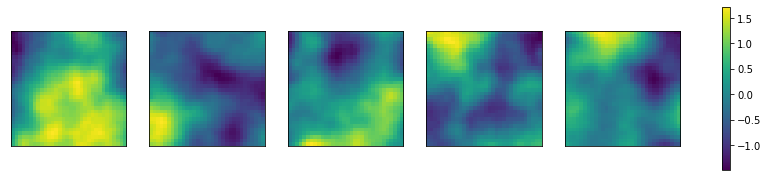

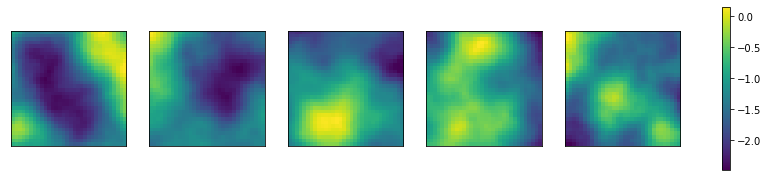

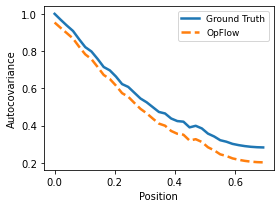

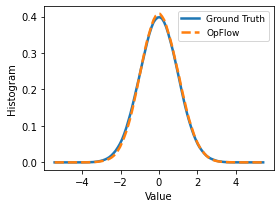

In [15]:
with torch.no_grad():
    Z = base_dist.rsample(sample_shape=(5,)).reshape(-1,ndim,ndim,1)
    X_hat = model.inverse(Z).detach().cpu().numpy()
    
    X_ground_truth = x_train[:5]
    Z_alt = base_dist.rsample(sample_shape=(5000,)).reshape(-1,ndim,ndim,1)

    z_train_iter = torch.split(Z_alt, 1000, dim=0)
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
        
    X_alt = torch.vstack(X_alt)        
    _, x_acovf = compute_acovf(X_alt.squeeze())
    _, x_acovf_true = compute_acovf(x_train.squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-5.5,5.5], density=True)

    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,:,:].squeeze()

        ax[i].imshow(x)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        #if i == 0:
            #ax[i].set_ylabel('OpFlow', fontsize=16)
        #ax[0].plot(x_ground_truth)
        #ax[0].set_title('Real')
        #ax[1].plot(x)
        #ax[1].set_title('OpFlow Generated')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])

    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)
    fig.colorbar(bar, ax=ax)

    #plt.show()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples.pdf")

    # covariance use position as x, adjust the size of histogram

    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    bar = ax[4].imshow(x_ground_truth)
    fig.colorbar(bar, ax=ax)
    #plt.savefig(f"paper_pdf/{folder}/{folder}_ground_truth.pdf")


    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos, x_acovf,c='#ff7f0e', ls='--', lw=2.5, label='OpFlow')
    #ax[0].set_ylim(0,1.1)
    ax.set_ylabel('Autocovariance')
    ax.set_xlabel('Position')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_autocov.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true,  c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    ax.set_ylabel('Histogram')
    ax.set_xlabel('Value')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_statistic.pdf")


## 2D Regression (strip observations)

In [16]:
from sklearn.gaussian_process.kernels import WhiteKernel

for param in G.parameters():
    param.requires_grad = False

In [12]:
ndim = 32
lr = 1e-3 
epochs = 5000
noise_level = 0.01

berno_mask = torch.zeros((ndim, ndim))
berno_mask[:,::10] = 1
#berno_mask[:,-1] = 1

mask_idx = np.where(berno_mask.reshape(-1) == 1)[0]
pos_mask = (berno_mask == 1)

u_obs_full = x_train[0:1,:,  :,0:1]
u_obs_part = u_obs_full[:,pos_mask,:].to(device)
u_obs_full = u_obs_full.squeeze()

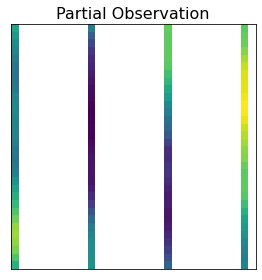

In [14]:
part_gt = u_obs_full.clone()
part_gt[~pos_mask] = np.nan
# plot the partial observation 
plt.imshow(part_gt)
plt.xticks([])
plt.yticks([])
plt.title('Partial Observation', fontsize=16)
plt.tight_layout()

## Get MAP result

In [36]:
class regression_opflow_a(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.a_target = nn.Parameter(torch.zeros(1,ndim, ndim, 1))
                                       
    def initialize(self, input):
        self.a_target.data = input.to(device)
        
    def target_u(self):
        return self.G.inverse(self.a_target)
        
    def logp(self):
        u = self.target_u()
        a, log_pa, log_det = self.G(u)
        return log_pa+log_det

    
def reg_process_a(reg_opflw_a, reg_optim_a, epochs, reg_scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        # maximize a posterior 
        reg_optim_a.zero_grad()
        loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_a.target_u()[:,pos_mask,:])**2)/noise_level
        #loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_u.u_target[:,pos_mask,:])**2)/noise_level
        loss2 = reg_opflow_a.logp()
        loss = -(loss1 + loss2)
        loss.backward()
        reg_optim_a.step()
        losses[epoch] = loss.item()
        if reg_scheduler is not None:
            reg_scheduler.step()
        print("epcoh:{}, loss:{}".format(epoch, loss.item()))
    return losses


In [37]:
reg_opflow_a = regression_opflow_a(G).to(device)
reg_optim_a = torch.optim.Adam(reg_opflow_a.parameters(), lr=lr , weight_decay=1e-4)

In [38]:
losses = reg_process_a(reg_opflow_a, reg_optim_a, epochs)

epcoh:0, loss:7682.318359375
epcoh:1, loss:7637.421875
epcoh:2, loss:7592.71337890625
epcoh:3, loss:7548.1845703125
epcoh:4, loss:7503.84619140625
epcoh:5, loss:7459.70166015625
epcoh:6, loss:7415.7451171875
epcoh:7, loss:7371.984375
epcoh:8, loss:7328.421875
epcoh:9, loss:7285.06298828125
epcoh:10, loss:7241.89453125
epcoh:11, loss:7198.95068359375
epcoh:12, loss:7156.19287109375
epcoh:13, loss:7113.65380859375
epcoh:14, loss:7071.31005859375
epcoh:15, loss:7029.193359375
epcoh:16, loss:6987.28369140625
epcoh:17, loss:6945.57861328125
epcoh:18, loss:6904.1201171875
epcoh:19, loss:6862.84765625
epcoh:20, loss:6821.8154296875
epcoh:21, loss:6780.9755859375
epcoh:22, loss:6740.365234375
epcoh:23, loss:6699.984375
epcoh:24, loss:6659.80126953125
epcoh:25, loss:6619.86962890625
epcoh:26, loss:6580.14453125
epcoh:27, loss:6540.623046875
epcoh:28, loss:6501.34521484375
epcoh:29, loss:6462.275390625
epcoh:30, loss:6423.4306640625
epcoh:31, loss:6384.8173828125
epcoh:32, loss:6346.41650390625


epcoh:258, loss:1422.407470703125
epcoh:259, loss:1410.56787109375
epcoh:260, loss:1398.78857421875
epcoh:261, loss:1387.0537109375
epcoh:262, loss:1375.370361328125
epcoh:263, loss:1363.728759765625
epcoh:264, loss:1352.14306640625
epcoh:265, loss:1340.599853515625
epcoh:266, loss:1329.110107421875
epcoh:267, loss:1317.663330078125
epcoh:268, loss:1306.264404296875
epcoh:269, loss:1294.912841796875
epcoh:270, loss:1283.611572265625
epcoh:271, loss:1272.35107421875
epcoh:272, loss:1261.1396484375
epcoh:273, loss:1249.972412109375
epcoh:274, loss:1238.848388671875
epcoh:275, loss:1227.776123046875
epcoh:276, loss:1216.74609375
epcoh:277, loss:1205.759521484375
epcoh:278, loss:1194.8203125
epcoh:279, loss:1183.9228515625
epcoh:280, loss:1173.07275390625
epcoh:281, loss:1162.26416015625
epcoh:282, loss:1151.4951171875
epcoh:283, loss:1140.7763671875
epcoh:284, loss:1130.095703125
epcoh:285, loss:1119.458740234375
epcoh:286, loss:1108.861328125
epcoh:287, loss:1098.313720703125
epcoh:288, 

epcoh:512, loss:-530.96728515625
epcoh:513, loss:-535.885986328125
epcoh:514, loss:-540.79296875
epcoh:515, loss:-545.68359375
epcoh:516, loss:-550.561767578125
epcoh:517, loss:-555.423583984375
epcoh:518, loss:-560.2725830078125
epcoh:519, loss:-565.1044921875
epcoh:520, loss:-569.923583984375
epcoh:521, loss:-574.731201171875
epcoh:522, loss:-579.5230712890625
epcoh:523, loss:-584.2984619140625
epcoh:524, loss:-589.0625
epcoh:525, loss:-593.8125
epcoh:526, loss:-598.5467529296875
epcoh:527, loss:-603.26708984375
epcoh:528, loss:-607.975830078125
epcoh:529, loss:-612.66796875
epcoh:530, loss:-617.348876953125
epcoh:531, loss:-622.014892578125
epcoh:532, loss:-626.667724609375
epcoh:533, loss:-631.3057861328125
epcoh:534, loss:-635.9332275390625
epcoh:535, loss:-640.543212890625
epcoh:536, loss:-645.1435546875
epcoh:537, loss:-649.7279052734375
epcoh:538, loss:-654.300048828125
epcoh:539, loss:-658.8564453125
epcoh:540, loss:-663.4017333984375
epcoh:541, loss:-667.9344482421875
epcoh:5

epcoh:751, loss:-1385.950927734375
epcoh:752, loss:-1388.4854736328125
epcoh:753, loss:-1391.01416015625
epcoh:754, loss:-1393.53369140625
epcoh:755, loss:-1396.0477294921875
epcoh:756, loss:-1398.5556640625
epcoh:757, loss:-1401.055908203125
epcoh:758, loss:-1403.5496826171875
epcoh:759, loss:-1406.03955078125
epcoh:760, loss:-1408.5201416015625
epcoh:761, loss:-1410.9937744140625
epcoh:762, loss:-1413.462890625
epcoh:763, loss:-1415.923828125
epcoh:764, loss:-1418.3795166015625
epcoh:765, loss:-1420.8275146484375
epcoh:766, loss:-1423.2724609375
epcoh:767, loss:-1425.709228515625
epcoh:768, loss:-1428.1378173828125
epcoh:769, loss:-1430.561279296875
epcoh:770, loss:-1432.97900390625
epcoh:771, loss:-1435.38818359375
epcoh:772, loss:-1437.794677734375
epcoh:773, loss:-1440.194580078125
epcoh:774, loss:-1442.585693359375
epcoh:775, loss:-1444.9718017578125
epcoh:776, loss:-1447.3515625
epcoh:777, loss:-1449.723876953125
epcoh:778, loss:-1452.09326171875
epcoh:779, loss:-1454.4542236328

epcoh:990, loss:-1840.314208984375
epcoh:991, loss:-1841.7095947265625
epcoh:992, loss:-1843.1031494140625
epcoh:993, loss:-1844.492431640625
epcoh:994, loss:-1845.878173828125
epcoh:995, loss:-1847.2603759765625
epcoh:996, loss:-1848.640625
epcoh:997, loss:-1850.017578125
epcoh:998, loss:-1851.3897705078125
epcoh:999, loss:-1852.7589111328125
epcoh:1000, loss:-1854.1263427734375
epcoh:1001, loss:-1855.489990234375
epcoh:1002, loss:-1856.849853515625
epcoh:1003, loss:-1858.207275390625
epcoh:1004, loss:-1859.560546875
epcoh:1005, loss:-1860.911376953125
epcoh:1006, loss:-1862.2587890625
epcoh:1007, loss:-1863.6036376953125
epcoh:1008, loss:-1864.94580078125
epcoh:1009, loss:-1866.282958984375
epcoh:1010, loss:-1867.6171875
epcoh:1011, loss:-1868.9488525390625
epcoh:1012, loss:-1870.279052734375
epcoh:1013, loss:-1871.603759765625
epcoh:1014, loss:-1872.926025390625
epcoh:1015, loss:-1874.2467041015625
epcoh:1016, loss:-1875.562744140625
epcoh:1017, loss:-1876.8759765625
epcoh:1018, los

epcoh:1223, loss:-2093.24609375
epcoh:1224, loss:-2094.07958984375
epcoh:1225, loss:-2094.911865234375
epcoh:1226, loss:-2095.740966796875
epcoh:1227, loss:-2096.570068359375
epcoh:1228, loss:-2097.39697265625
epcoh:1229, loss:-2098.220947265625
epcoh:1230, loss:-2099.04443359375
epcoh:1231, loss:-2099.86669921875
epcoh:1232, loss:-2100.686279296875
epcoh:1233, loss:-2101.504638671875
epcoh:1234, loss:-2102.32080078125
epcoh:1235, loss:-2103.136474609375
epcoh:1236, loss:-2103.94873046875
epcoh:1237, loss:-2104.760986328125
epcoh:1238, loss:-2105.571044921875
epcoh:1239, loss:-2106.37939453125
epcoh:1240, loss:-2107.185546875
epcoh:1241, loss:-2107.98974609375
epcoh:1242, loss:-2108.794189453125
epcoh:1243, loss:-2109.595947265625
epcoh:1244, loss:-2110.3955078125
epcoh:1245, loss:-2111.193115234375
epcoh:1246, loss:-2111.990966796875
epcoh:1247, loss:-2112.78515625
epcoh:1248, loss:-2113.5791015625
epcoh:1249, loss:-2114.37158203125
epcoh:1250, loss:-2115.160888671875
epcoh:1251, loss

epcoh:1459, loss:-2250.949462890625
epcoh:1460, loss:-2251.48193359375
epcoh:1461, loss:-2252.013427734375
epcoh:1462, loss:-2252.544189453125
epcoh:1463, loss:-2253.07470703125
epcoh:1464, loss:-2253.603271484375
epcoh:1465, loss:-2254.131103515625
epcoh:1466, loss:-2254.65869140625
epcoh:1467, loss:-2255.18505859375
epcoh:1468, loss:-2255.7099609375
epcoh:1469, loss:-2256.234619140625
epcoh:1470, loss:-2256.75830078125
epcoh:1471, loss:-2257.281005859375
epcoh:1472, loss:-2257.802734375
epcoh:1473, loss:-2258.32373046875
epcoh:1474, loss:-2258.8427734375
epcoh:1475, loss:-2259.362060546875
epcoh:1476, loss:-2259.880859375
epcoh:1477, loss:-2260.39697265625
epcoh:1478, loss:-2260.914794921875
epcoh:1479, loss:-2261.4296875
epcoh:1480, loss:-2261.944580078125
epcoh:1481, loss:-2262.4580078125
epcoh:1482, loss:-2262.97119140625
epcoh:1483, loss:-2263.48291015625
epcoh:1484, loss:-2263.99365234375
epcoh:1485, loss:-2264.50439453125
epcoh:1486, loss:-2265.013916015625
epcoh:1487, loss:-22

epcoh:1694, loss:-2354.95947265625
epcoh:1695, loss:-2355.32666015625
epcoh:1696, loss:-2355.69287109375
epcoh:1697, loss:-2356.05908203125
epcoh:1698, loss:-2356.423828125
epcoh:1699, loss:-2356.7890625
epcoh:1700, loss:-2357.15380859375
epcoh:1701, loss:-2357.518310546875
epcoh:1702, loss:-2357.882080078125
epcoh:1703, loss:-2358.244384765625
epcoh:1704, loss:-2358.60595703125
epcoh:1705, loss:-2358.968505859375
epcoh:1706, loss:-2359.330078125
epcoh:1707, loss:-2359.691162109375
epcoh:1708, loss:-2360.051513671875
epcoh:1709, loss:-2360.41162109375
epcoh:1710, loss:-2360.7705078125
epcoh:1711, loss:-2361.12939453125
epcoh:1712, loss:-2361.4873046875
epcoh:1713, loss:-2361.844970703125
epcoh:1714, loss:-2362.202880859375
epcoh:1715, loss:-2362.56005859375
epcoh:1716, loss:-2362.916015625
epcoh:1717, loss:-2363.27197265625
epcoh:1718, loss:-2363.62744140625
epcoh:1719, loss:-2363.981689453125
epcoh:1720, loss:-2364.33642578125
epcoh:1721, loss:-2364.68994140625
epcoh:1722, loss:-2365.

epcoh:1929, loss:-2428.82421875
epcoh:1930, loss:-2429.09326171875
epcoh:1931, loss:-2429.36181640625
epcoh:1932, loss:-2429.629638671875
epcoh:1933, loss:-2429.89794921875
epcoh:1934, loss:-2430.16552734375
epcoh:1935, loss:-2430.432861328125
epcoh:1936, loss:-2430.69921875
epcoh:1937, loss:-2430.965576171875
epcoh:1938, loss:-2431.232666015625
epcoh:1939, loss:-2431.498046875
epcoh:1940, loss:-2431.76416015625
epcoh:1941, loss:-2432.029052734375
epcoh:1942, loss:-2432.293701171875
epcoh:1943, loss:-2432.55859375
epcoh:1944, loss:-2432.82275390625
epcoh:1945, loss:-2433.0869140625
epcoh:1946, loss:-2433.350341796875
epcoh:1947, loss:-2433.612548828125
epcoh:1948, loss:-2433.876953125
epcoh:1949, loss:-2434.13916015625
epcoh:1950, loss:-2434.402099609375
epcoh:1951, loss:-2434.663330078125
epcoh:1952, loss:-2434.92529296875
epcoh:1953, loss:-2435.187255859375
epcoh:1954, loss:-2435.447998046875
epcoh:1955, loss:-2435.70849609375
epcoh:1956, loss:-2435.969970703125
epcoh:1957, loss:-243

epcoh:2163, loss:-2483.85498046875
epcoh:2164, loss:-2484.060302734375
epcoh:2165, loss:-2484.265380859375
epcoh:2166, loss:-2484.469970703125
epcoh:2167, loss:-2484.675048828125
epcoh:2168, loss:-2484.879638671875
epcoh:2169, loss:-2485.083740234375
epcoh:2170, loss:-2485.287353515625
epcoh:2171, loss:-2485.490966796875
epcoh:2172, loss:-2485.69482421875
epcoh:2173, loss:-2485.89794921875
epcoh:2174, loss:-2486.101318359375
epcoh:2175, loss:-2486.303466796875
epcoh:2176, loss:-2486.506591796875
epcoh:2177, loss:-2486.708740234375
epcoh:2178, loss:-2486.910888671875
epcoh:2179, loss:-2487.11328125
epcoh:2180, loss:-2487.31494140625
epcoh:2181, loss:-2487.5166015625
epcoh:2182, loss:-2487.718017578125
epcoh:2183, loss:-2487.919189453125
epcoh:2184, loss:-2488.11962890625
epcoh:2185, loss:-2488.3203125
epcoh:2186, loss:-2488.521484375
epcoh:2187, loss:-2488.720458984375
epcoh:2188, loss:-2488.92138671875
epcoh:2189, loss:-2489.120849609375
epcoh:2190, loss:-2489.3203125
epcoh:2191, loss:

epcoh:2398, loss:-2526.561279296875
epcoh:2399, loss:-2526.72216796875
epcoh:2400, loss:-2526.8818359375
epcoh:2401, loss:-2527.04248046875
epcoh:2402, loss:-2527.201904296875
epcoh:2403, loss:-2527.36181640625
epcoh:2404, loss:-2527.521240234375
epcoh:2405, loss:-2527.680908203125
epcoh:2406, loss:-2527.839599609375
epcoh:2407, loss:-2527.998779296875
epcoh:2408, loss:-2528.15771484375
epcoh:2409, loss:-2528.316162109375
epcoh:2410, loss:-2528.47509765625
epcoh:2411, loss:-2528.6328125
epcoh:2412, loss:-2528.791259765625
epcoh:2413, loss:-2528.949462890625
epcoh:2414, loss:-2529.107666015625
epcoh:2415, loss:-2529.264892578125
epcoh:2416, loss:-2529.423095703125
epcoh:2417, loss:-2529.579345703125
epcoh:2418, loss:-2529.737060546875
epcoh:2419, loss:-2529.89453125
epcoh:2420, loss:-2530.051513671875
epcoh:2421, loss:-2530.207763671875
epcoh:2422, loss:-2530.36474609375
epcoh:2423, loss:-2530.52099609375
epcoh:2424, loss:-2530.67724609375
epcoh:2425, loss:-2530.8330078125
epcoh:2426, l

epcoh:2633, loss:-2560.1103515625
epcoh:2634, loss:-2560.23681640625
epcoh:2635, loss:-2560.363525390625
epcoh:2636, loss:-2560.48974609375
epcoh:2637, loss:-2560.615966796875
epcoh:2638, loss:-2560.741455078125
epcoh:2639, loss:-2560.867431640625
epcoh:2640, loss:-2560.9931640625
epcoh:2641, loss:-2561.118896484375
epcoh:2642, loss:-2561.24462890625
epcoh:2643, loss:-2561.370361328125
epcoh:2644, loss:-2561.495361328125
epcoh:2645, loss:-2561.620849609375
epcoh:2646, loss:-2561.74609375
epcoh:2647, loss:-2561.8701171875
epcoh:2648, loss:-2561.9951171875
epcoh:2649, loss:-2562.120361328125
epcoh:2650, loss:-2562.24462890625
epcoh:2651, loss:-2562.368896484375
epcoh:2652, loss:-2562.492919921875
epcoh:2653, loss:-2562.61767578125
epcoh:2654, loss:-2562.7412109375
epcoh:2655, loss:-2562.865234375
epcoh:2656, loss:-2562.989501953125
epcoh:2657, loss:-2563.11328125
epcoh:2658, loss:-2563.236572265625
epcoh:2659, loss:-2563.360107421875
epcoh:2660, loss:-2563.483154296875
epcoh:2661, loss:-

epcoh:2868, loss:-2586.648681640625
epcoh:2869, loss:-2586.749267578125
epcoh:2870, loss:-2586.848876953125
epcoh:2871, loss:-2586.949462890625
epcoh:2872, loss:-2587.049560546875
epcoh:2873, loss:-2587.149169921875
epcoh:2874, loss:-2587.2490234375
epcoh:2875, loss:-2587.34912109375
epcoh:2876, loss:-2587.447998046875
epcoh:2877, loss:-2587.54736328125
epcoh:2878, loss:-2587.647216796875
epcoh:2879, loss:-2587.74609375
epcoh:2880, loss:-2587.844970703125
epcoh:2881, loss:-2587.944580078125
epcoh:2882, loss:-2588.043212890625
epcoh:2883, loss:-2588.141845703125
epcoh:2884, loss:-2588.2412109375
epcoh:2885, loss:-2588.33984375
epcoh:2886, loss:-2588.438232421875
epcoh:2887, loss:-2588.536865234375
epcoh:2888, loss:-2588.63525390625
epcoh:2889, loss:-2588.7333984375
epcoh:2890, loss:-2588.8310546875
epcoh:2891, loss:-2588.929443359375
epcoh:2892, loss:-2589.02734375
epcoh:2893, loss:-2589.12548828125
epcoh:2894, loss:-2589.22314453125
epcoh:2895, loss:-2589.321533203125
epcoh:2896, loss:

epcoh:3103, loss:-2607.6689453125
epcoh:3104, loss:-2607.74853515625
epcoh:3105, loss:-2607.82763671875
epcoh:3106, loss:-2607.906982421875
epcoh:3107, loss:-2607.986083984375
epcoh:3108, loss:-2608.0654296875
epcoh:3109, loss:-2608.144287109375
epcoh:3110, loss:-2608.22314453125
epcoh:3111, loss:-2608.3017578125
epcoh:3112, loss:-2608.381103515625
epcoh:3113, loss:-2608.45947265625
epcoh:3114, loss:-2608.537841796875
epcoh:3115, loss:-2608.615966796875
epcoh:3116, loss:-2608.694580078125
epcoh:3117, loss:-2608.772705078125
epcoh:3118, loss:-2608.851318359375
epcoh:3119, loss:-2608.9296875
epcoh:3120, loss:-2609.0078125
epcoh:3121, loss:-2609.08544921875
epcoh:3122, loss:-2609.163330078125
epcoh:3123, loss:-2609.2412109375
epcoh:3124, loss:-2609.319091796875
epcoh:3125, loss:-2609.39697265625
epcoh:3126, loss:-2609.474609375
epcoh:3127, loss:-2609.552001953125
epcoh:3128, loss:-2609.62939453125
epcoh:3129, loss:-2609.706787109375
epcoh:3130, loss:-2609.783935546875
epcoh:3131, loss:-26

epcoh:3338, loss:-2624.292236328125
epcoh:3339, loss:-2624.354736328125
epcoh:3340, loss:-2624.416748046875
epcoh:3341, loss:-2624.479736328125
epcoh:3342, loss:-2624.54248046875
epcoh:3343, loss:-2624.6044921875
epcoh:3344, loss:-2624.667236328125
epcoh:3345, loss:-2624.7294921875
epcoh:3346, loss:-2624.791259765625
epcoh:3347, loss:-2624.853515625
epcoh:3348, loss:-2624.91552734375
epcoh:3349, loss:-2624.97802734375
epcoh:3350, loss:-2625.0400390625
epcoh:3351, loss:-2625.1015625
epcoh:3352, loss:-2625.16357421875
epcoh:3353, loss:-2625.22509765625
epcoh:3354, loss:-2625.286865234375
epcoh:3355, loss:-2625.348388671875
epcoh:3356, loss:-2625.41015625
epcoh:3357, loss:-2625.471923828125
epcoh:3358, loss:-2625.533447265625
epcoh:3359, loss:-2625.5947265625
epcoh:3360, loss:-2625.65625
epcoh:3361, loss:-2625.71728515625
epcoh:3362, loss:-2625.778564453125
epcoh:3363, loss:-2625.83984375
epcoh:3364, loss:-2625.90087890625
epcoh:3365, loss:-2625.9619140625
epcoh:3366, loss:-2626.022949218

epcoh:3574, loss:-2637.450927734375
epcoh:3575, loss:-2637.5
epcoh:3576, loss:-2637.54931640625
epcoh:3577, loss:-2637.5986328125
epcoh:3578, loss:-2637.6474609375
epcoh:3579, loss:-2637.696533203125
epcoh:3580, loss:-2637.745849609375
epcoh:3581, loss:-2637.794677734375
epcoh:3582, loss:-2637.84375
epcoh:3583, loss:-2637.892578125
epcoh:3584, loss:-2637.94091796875
epcoh:3585, loss:-2637.990234375
epcoh:3586, loss:-2638.0390625
epcoh:3587, loss:-2638.087646484375
epcoh:3588, loss:-2638.135986328125
epcoh:3589, loss:-2638.184814453125
epcoh:3590, loss:-2638.233154296875
epcoh:3591, loss:-2638.28173828125
epcoh:3592, loss:-2638.330322265625
epcoh:3593, loss:-2638.378662109375
epcoh:3594, loss:-2638.427001953125
epcoh:3595, loss:-2638.475341796875
epcoh:3596, loss:-2638.5234375
epcoh:3597, loss:-2638.57177734375
epcoh:3598, loss:-2638.6201171875
epcoh:3599, loss:-2638.66796875
epcoh:3600, loss:-2638.71630859375
epcoh:3601, loss:-2638.763916015625
epcoh:3602, loss:-2638.811767578125
epcoh

epcoh:3809, loss:-2647.7470703125
epcoh:3810, loss:-2647.7861328125
epcoh:3811, loss:-2647.824462890625
epcoh:3812, loss:-2647.86328125
epcoh:3813, loss:-2647.901611328125
epcoh:3814, loss:-2647.940185546875
epcoh:3815, loss:-2647.978759765625
epcoh:3816, loss:-2648.016845703125
epcoh:3817, loss:-2648.055419921875
epcoh:3818, loss:-2648.093994140625
epcoh:3819, loss:-2648.1318359375
epcoh:3820, loss:-2648.17041015625
epcoh:3821, loss:-2648.208984375
epcoh:3822, loss:-2648.246826171875
epcoh:3823, loss:-2648.285400390625
epcoh:3824, loss:-2648.323486328125
epcoh:3825, loss:-2648.361083984375
epcoh:3826, loss:-2648.399658203125
epcoh:3827, loss:-2648.437255859375
epcoh:3828, loss:-2648.475830078125
epcoh:3829, loss:-2648.513427734375
epcoh:3830, loss:-2648.55126953125
epcoh:3831, loss:-2648.5888671875
epcoh:3832, loss:-2648.627197265625
epcoh:3833, loss:-2648.66455078125
epcoh:3834, loss:-2648.702392578125
epcoh:3835, loss:-2648.740234375
epcoh:3836, loss:-2648.77783203125
epcoh:3837, lo

epcoh:4042, loss:-2655.75634765625
epcoh:4043, loss:-2655.787109375
epcoh:4044, loss:-2655.81689453125
epcoh:4045, loss:-2655.847412109375
epcoh:4046, loss:-2655.877685546875
epcoh:4047, loss:-2655.90771484375
epcoh:4048, loss:-2655.93798828125
epcoh:4049, loss:-2655.96875
epcoh:4050, loss:-2655.998046875
epcoh:4051, loss:-2656.0283203125
epcoh:4052, loss:-2656.058349609375
epcoh:4053, loss:-2656.08837890625
epcoh:4054, loss:-2656.11865234375
epcoh:4055, loss:-2656.14892578125
epcoh:4056, loss:-2656.1787109375
epcoh:4057, loss:-2656.208251953125
epcoh:4058, loss:-2656.238037109375
epcoh:4059, loss:-2656.26806640625
epcoh:4060, loss:-2656.2978515625
epcoh:4061, loss:-2656.32763671875
epcoh:4062, loss:-2656.357177734375
epcoh:4063, loss:-2656.386962890625
epcoh:4064, loss:-2656.416748046875
epcoh:4065, loss:-2656.4462890625
epcoh:4066, loss:-2656.475830078125
epcoh:4067, loss:-2656.505615234375
epcoh:4068, loss:-2656.535400390625
epcoh:4069, loss:-2656.564697265625
epcoh:4070, loss:-2656

epcoh:4276, loss:-2662.050048828125
epcoh:4277, loss:-2662.07373046875
epcoh:4278, loss:-2662.09765625
epcoh:4279, loss:-2662.12109375
epcoh:4280, loss:-2662.14453125
epcoh:4281, loss:-2662.168212890625
epcoh:4282, loss:-2662.191162109375
epcoh:4283, loss:-2662.215576171875
epcoh:4284, loss:-2662.23876953125
epcoh:4285, loss:-2662.2626953125
epcoh:4286, loss:-2662.28564453125
epcoh:4287, loss:-2662.30908203125
epcoh:4288, loss:-2662.332763671875
epcoh:4289, loss:-2662.356201171875
epcoh:4290, loss:-2662.379150390625
epcoh:4291, loss:-2662.40283203125
epcoh:4292, loss:-2662.426025390625
epcoh:4293, loss:-2662.449462890625
epcoh:4294, loss:-2662.47216796875
epcoh:4295, loss:-2662.495849609375
epcoh:4296, loss:-2662.51904296875
epcoh:4297, loss:-2662.542236328125
epcoh:4298, loss:-2662.565185546875
epcoh:4299, loss:-2662.58837890625
epcoh:4300, loss:-2662.61181640625
epcoh:4301, loss:-2662.634521484375
epcoh:4302, loss:-2662.65771484375
epcoh:4303, loss:-2662.680908203125
epcoh:4304, loss

epcoh:4510, loss:-2666.953857421875
epcoh:4511, loss:-2666.97265625
epcoh:4512, loss:-2666.99072265625
epcoh:4513, loss:-2667.009033203125
epcoh:4514, loss:-2667.02734375
epcoh:4515, loss:-2667.0458984375
epcoh:4516, loss:-2667.064208984375
epcoh:4517, loss:-2667.082763671875
epcoh:4518, loss:-2667.100830078125
epcoh:4519, loss:-2667.11865234375
epcoh:4520, loss:-2667.13720703125
epcoh:4521, loss:-2667.1552734375
epcoh:4522, loss:-2667.173828125
epcoh:4523, loss:-2667.19189453125
epcoh:4524, loss:-2667.2099609375
epcoh:4525, loss:-2667.22802734375
epcoh:4526, loss:-2667.24609375
epcoh:4527, loss:-2667.2646484375
epcoh:4528, loss:-2667.2822265625
epcoh:4529, loss:-2667.300048828125
epcoh:4530, loss:-2667.318603515625
epcoh:4531, loss:-2667.33642578125
epcoh:4532, loss:-2667.354736328125
epcoh:4533, loss:-2667.37255859375
epcoh:4534, loss:-2667.390869140625
epcoh:4535, loss:-2667.408447265625
epcoh:4536, loss:-2667.42626953125
epcoh:4537, loss:-2667.444580078125
epcoh:4538, loss:-2667.46

epcoh:4744, loss:-2670.7607421875
epcoh:4745, loss:-2670.77490234375
epcoh:4746, loss:-2670.789306640625
epcoh:4747, loss:-2670.803466796875
epcoh:4748, loss:-2670.8173828125
epcoh:4749, loss:-2670.83203125
epcoh:4750, loss:-2670.845947265625
epcoh:4751, loss:-2670.860107421875
epcoh:4752, loss:-2670.87451171875
epcoh:4753, loss:-2670.888671875
epcoh:4754, loss:-2670.90283203125
epcoh:4755, loss:-2670.916748046875
epcoh:4756, loss:-2670.9306640625
epcoh:4757, loss:-2670.945068359375
epcoh:4758, loss:-2670.958984375
epcoh:4759, loss:-2670.972900390625
epcoh:4760, loss:-2670.9873046875
epcoh:4761, loss:-2671.0009765625
epcoh:4762, loss:-2671.01513671875
epcoh:4763, loss:-2671.029052734375
epcoh:4764, loss:-2671.04296875
epcoh:4765, loss:-2671.05712890625
epcoh:4766, loss:-2671.070556640625
epcoh:4767, loss:-2671.084716796875
epcoh:4768, loss:-2671.09912109375
epcoh:4769, loss:-2671.112548828125
epcoh:4770, loss:-2671.126708984375
epcoh:4771, loss:-2671.140625
epcoh:4772, loss:-2671.15429

epcoh:4979, loss:-2673.716552734375
epcoh:4980, loss:-2673.7275390625
epcoh:4981, loss:-2673.738525390625
epcoh:4982, loss:-2673.749267578125
epcoh:4983, loss:-2673.76025390625
epcoh:4984, loss:-2673.771240234375
epcoh:4985, loss:-2673.7822265625
epcoh:4986, loss:-2673.793212890625
epcoh:4987, loss:-2673.804443359375
epcoh:4988, loss:-2673.81494140625
epcoh:4989, loss:-2673.82568359375
epcoh:4990, loss:-2673.836669921875
epcoh:4991, loss:-2673.84765625
epcoh:4992, loss:-2673.858642578125
epcoh:4993, loss:-2673.869384765625
epcoh:4994, loss:-2673.88037109375
epcoh:4995, loss:-2673.890869140625
epcoh:4996, loss:-2673.90185546875
epcoh:4997, loss:-2673.91259765625
epcoh:4998, loss:-2673.92333984375
epcoh:4999, loss:-2673.934326171875


In [31]:
### validation of the MAP result

In [39]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    #ax.set_ylim([-3, 3])

In [40]:
u_opflow = reg_opflow_a.target_u().detach() # u_opflow : [ndim, ndim]
u_opflow_old = u_opflow #save a copy

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)
kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x)
gpr_model_ground_truth = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)

x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model

(1024, 2)


### SGLD sampling

In [43]:
import sys
sys.path.insert(0, '../')

from imp import reload

import sampling_SGLD

import sampling_SGLD.samplers


import sampling_SGLD.SGLD
reload(sampling_SGLD.SGLD)

# reload order matter, sampler should be after sgld
reload(sampling_SGLD.samplers)
from sampling_SGLD.samplers import LangevinDynamics
import copy
from tqdm import tqdm

In [44]:
def nl_pdf_a(a, noise_level=noise_level):
    # return negative loglikehood
    u_from_a = G.inverse(a)
    loss1 = -0.5*torch.sum((u_obs_part - u_from_a[:,pos_mask,:])**2)/noise_level
    
    _, log_pa, log_det = G(u_from_a) 
    loss2 = log_pa + log_det
    
    loss = -(loss1 + loss2) 
    return loss

In [45]:
a_opflow_copy = reg_opflow_a.a_target.data.cpu().detach().clone()
u_opflow_copy = reg_opflow_a.target_u().cpu().detach().clone()

In [59]:
## initialize with the MAP result
x = torch.zeros_like(a_opflow_copy, requires_grad=True)
x.data = a_opflow_copy.to(device)
#x = nn.Parameter(u_opflow_copy, requires_grad=True).to(device)
#x = torch.zeros([2], requires_grad=True, device=device)

temperature = 1.0
max_itr = int(2e4)
#max_itr = int(1e4)
## should sample 6e4 to guarantee the smooth. 


# only designed for functional SGLD
langevin_dynamics = LangevinDynamics(x,
                                     nl_pdf_a,
                                     lr=5e-3,
                                     lr_final=4e-3,
                                     max_itr=max_itr,
                                     device=device,
                                     base_dist = base_dist,
                                     temperature = temperature,
                                     )


hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample(epoch=j)
    loss_log.append(loss)
    if j % 10 == 0:
        hist_samples.append(est.cpu().numpy())

update
Tempertaure:1.0
start, white noise on A


100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [48:55<00:00,  6.81it/s]


In [60]:
with torch.no_grad():
    a_samples_all = torch.Tensor(np.vstack(hist_samples)).to(device)
    u_samples_all = G.inverse(a_samples_all)

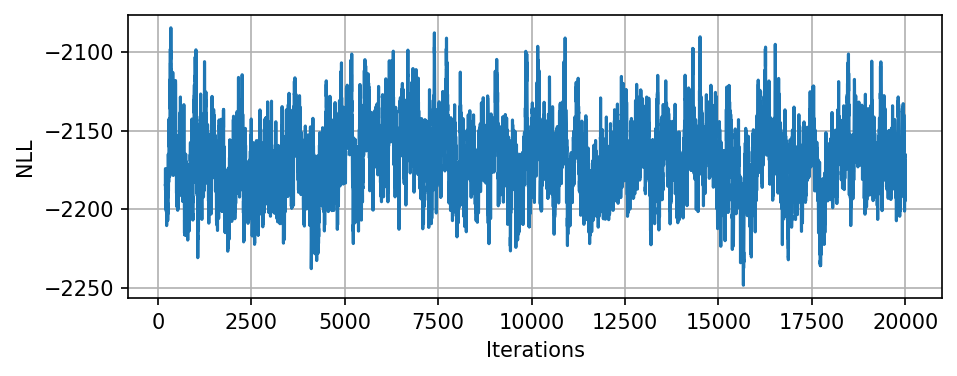

In [61]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(np.arange(200, len(loss_log)),loss_log[200:])
#plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel('NLL')
#plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

In [62]:
len(hist_samples)

2000

In [63]:

## calculate the mean predicted from OpFlow and Ground Truht 
est_samples = u_samples_all.detach().cpu().numpy()
est_samples = est_samples[20:]
#est_samples = est_samples[::50]

sample_mean = np.mean(est_samples, axis=0).squeeze()
sample_std = np.std(est_samples, axis=0).squeeze()

### Final Plots

In [16]:
opflow_mean = sample_mean
opflow_std = sample_std

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)
kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x)
gpr_model_ground_truth = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)

x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model

(1024, 2)


In [69]:
saved_folder = 'GRF2GRF_set1_lr_1e_3_reg'
if not os.path.exists(f"Regression_results/{saved_folder}"):
    os.makedirs(f"Regression_results/{saved_folder}")

In [66]:
opflow_mean = sample_mean
opflow_std = sample_std
print(y_std.min(), y_std.max())

0.055192190706002814 0.24786631475641374


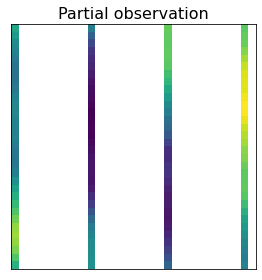

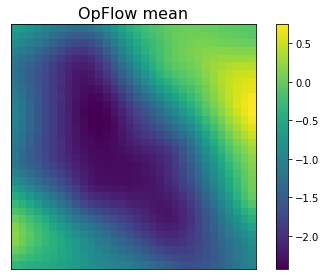

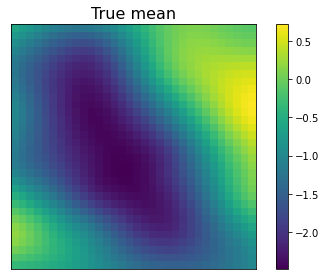

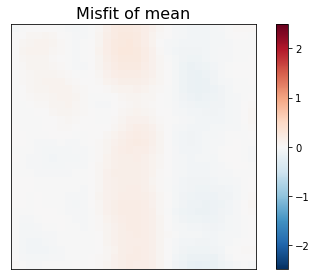

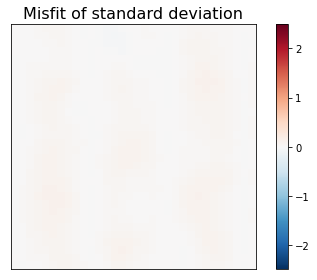

In [17]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_mean = y_mean.reshape(32,32)
y_std = y_std.reshape(32,32)
y_samples = gpr_model_ground_truth.sample_y(X, 5000).reshape(32,32,-1)

part_gt = u_obs_full.clone()
part_gt[~pos_mask] = np.nan
# plot the partial observation 
plt.imshow(part_gt)
plt.xticks([])
plt.yticks([])
plt.title('Partial observation', fontsize=16)
plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_partial_obs.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex3_partial_obs.pdf")

plt.figure()
plt.imshow(sample_mean)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('OpFlow mean', fontsize=16)
plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_opflow_mean.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex3_opflow_mean.pdf")

plt.figure()
plt.imshow(y_mean)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('True mean', fontsize=16)
plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_true_mean.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex3_true_mean.pdf")

plt.figure()
relative_error = (sample_mean - y_mean)
norm = TwoSlopeNorm(vmin= y_mean.min(), vmax= -y_mean.min(),vcenter=0)
#plt.imshow(relative_error, vmin= y_mean.min(), vmax= y_mean.max())
plt.imshow(relative_error, norm=norm,cmap="RdBu_r")
#pc = plt.pcolormesh(x,y,z, norm=norm, cmap="RdBu_r")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Misfit of mean', fontsize=16)
plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_misfit_mean.pdf")
plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex3_misfit_mean.pdf")

plt.figure()
relative_error = (sample_mean - y_mean)
norm = TwoSlopeNorm(vmin= y_mean.min(), vmax= -y_mean.min(),vcenter=0)
#plt.imshow(relative_error, vmin= y_mean.min(), vmax= y_mean.max())
plt.imshow(y_std-opflow_std, norm=norm, cmap="RdBu_r")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Misfit of standard deviation', fontsize=16)
plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_misfit_std.pdf")
plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex3_misfit_std.pdf")

### 

### Generate 3 representative scenarios

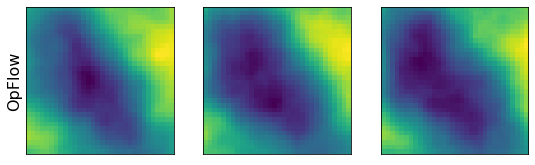

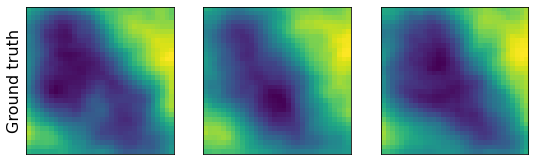

In [77]:
## each one generate 3 plots
## For the scenario, select 3 representative scenario for OpFlow and Ground Truth

#random_idx = np.array([280, 73, 470]) # used for the paper
#random_idx_gt = np.array([25, 7,380]) # used for the paper 
random_idx = np.random.choice(len(est_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    x_opflow = est_samples[random_idx[i]].squeeze()
    ax[i].imshow(x_opflow)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('OpFlow', fontsize=16)
        
#plt.tight_layout()
plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex3_scen_opflow.pdf")     
        
random_idx_gt = np.random.choice(len(y_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    y_example = y_samples[:,:,random_idx_gt[i]].squeeze()
    ax[i].imshow(y_example)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('Ground truth', fontsize=16)
#plt.tight_layout()
plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex3_scen_gt.pdf")   

In [78]:
## report he MSE_std 

import h5py
f = h5py.File(f"Regression_results/{saved_folder}_ex3.h5py", "w")
f.create_dataset('u_full_obs', data=u_obs_full.numpy())
f.create_dataset('x_obs_idx', data=mask_idx)
f.create_dataset('a_opflow_map', data=a_opflow_copy.squeeze().numpy())
f.create_dataset('sample_from_opflow', data=u_samples_all.detach().cpu().numpy())
f.close()